In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import glob
from PIL import Image
import numpy as np
all_images = []
all_labels = []
filenames=[]
ages=[]
img_size=(80, 100)
for f in glob.glob('c:\\data\\xray\\**\\*.jpg', recursive=True):
    arr = f.split('\\')
    arr2 = arr[3].split("_")
    if arr2[1] == 'M':
    # if arr2[1] == 'F':
        img = Image.open(f)
        filenames.append(arr[-1])
        img_resize = img.resize((img_size[0], img_size[1]))
        all_images.append(img_resize)
        age = int(arr2[2].replace('yr', ''))
        ages.append(age)

In [3]:
filenames[:10]

['332_M.jpg',
 '333_M.jpg',
 '334_M.jpg',
 '335_M.jpg',
 '336_M.jpg',
 '337_M.jpg',
 '338_M.jpg',
 '339_M.jpg',
 '340_M.jpg',
 '341_M.jpg']

In [4]:
items = list(zip(filenames, ages, all_images))
items[:10]

[('332_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('333_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('334_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('335_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('336_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('337_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('338_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('339_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('340_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>),
 ('341_M.jpg', 10, <PIL.Image.Image image mode=RGB size=80x100>)]

In [5]:
len(all_images)

665

In [6]:
np.array(all_images[0]).shape

(100, 80, 3)

In [7]:
X=np.empty((1, img_size[0], img_size[1], 3))
for img in all_images:
    X=np.vstack((X,np.array(img).reshape(1, img_size[0], img_size[1], 3)))
X.shape

(666, 80, 100, 3)

In [8]:
X = np.delete(X, (0), axis=0)

In [9]:
X.shape

(665, 80, 100, 3)

In [10]:
y = np.array(ages)
y[:10]

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

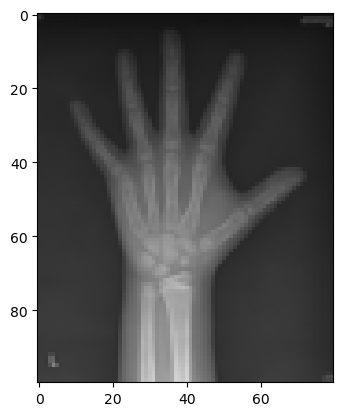

In [11]:
import matplotlib.pyplot as plt
plt.imshow(all_images[0])
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, 
                                                    shuffle=True, random_state=10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((532, 80, 100, 3), (133, 80, 100, 3), (532,), (133,))

In [13]:
import pandas as pd
pd.DataFrame(y_train).value_counts()

4     40
5     40
6     40
7     40
8     40
9     40
10    40
11    40
12    40
13    40
14    40
15    36
3     25
16    24
17     7
dtype: int64

In [14]:
X_train = X_train.reshape(-1, img_size[0]*img_size[1]*3)
X_test = X_test.reshape(-1, img_size[0]*img_size[1]*3)

In [15]:
X_train = X_train/255.
X_test = X_test/255.

In [16]:
X_train = X_train.reshape(-1, img_size[0], img_size[1], 3)
X_test = X_test.reshape(-1, img_size[0], img_size[1], 3)

In [17]:
y_train_backup = y_train
y_test_backup = y_test

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
model = Sequential()
model.add(Conv2D(64, (3,3), padding="same",
input_shape = X_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3), activation="relu"))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="rmsprop", loss="mae", metrics=["mae"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 100, 64)       1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 50, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 48, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 22, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 23936)             0

In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((532, 80, 100, 3), (532,), (133, 80, 100, 3), (133,))

In [20]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("c:/data/model/xray_m_best.h5", monitor='val_mae', 
                             verbose=1, save_best_only=True, mode='min')
# checkpoint = ModelCheckpoint("c:/data/model/xray_f_best.h5", monitor='val_mae', 
#                              verbose=1, save_best_only=True, mode='min')
hist = model.fit(X_train, y_train, batch_size=32, validation_split=0.2, epochs=100, 
                 callbacks=[checkpoint])

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 6.5066 - mae: 6.5066
Epoch 1: val_mae improved from inf to 4.09655, saving model to c:/data/model\xray_m_best.h5
14/14 [==============================] - 3s 68ms/step - loss: 6.5066 - mae: 6.5066 - val_loss: 4.0966 - val_mae: 4.0966
Epoch 2/100
13/14 [==========================>...] - ETA: 0s - loss: 3.7959 - mae: 3.7959
Epoch 2: val_mae improved from 4.09655 to 3.27443, saving model to c:/data/model\xray_m_best.h5
14/14 [==============================] - 0s 35ms/step - loss: 3.8026 - mae: 3.8026 - val_loss: 3.2744 - val_mae: 3.2744
Epoch 3/100
13/14 [==========================>...] - ETA: 0s - loss: 3.3549 - mae: 3.3549
Epoch 3: val_mae did not improve from 3.27443
14/14 [==============================] - 0s 31ms/step - loss: 3.4474 - mae: 3.4474 - val_loss: 4.1065 - val_mae: 4.1065
Epoch 4/100
13/14 [==========================>...] - ETA: 0s - loss: 3.4553 - mae: 3.4553
Epoch 4: val_mae did not improve from 3.27443


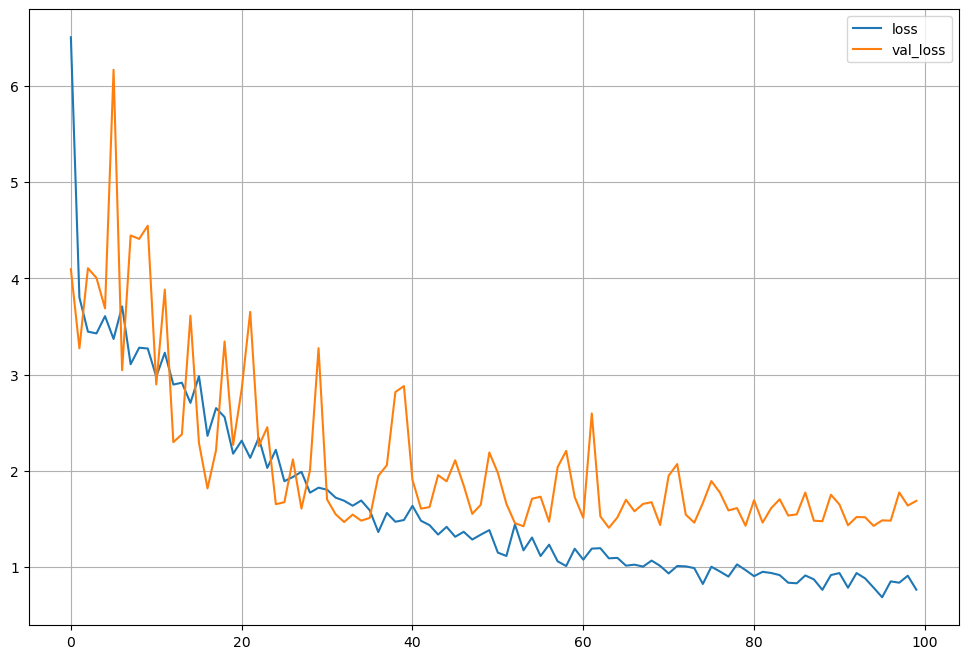

In [21]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.grid()
plt.show()

In [22]:
from tensorflow.keras.models import load_model
model = load_model('c:/data/model/xray_m_best.h5')
# model = load_model('c:/data/model/xray_f_best.h5')
scores = model.evaluate(X_train, y_train, verbose=1)
print(scores)

17/17 [==============================] - 0s 14ms/step - loss: 0.8260 - mae: 0.8260
[0.8260098695755005, 0.8260098695755005]


In [23]:
model = load_model('c:/data/model/xray_m_best.h5')
# model = load_model('c:/data/model/xray_f_best.h5')
scores = model.evaluate(X_test, y_test, verbose=1)
print(scores)

5/5 [==============================] - 0s 23ms/step - loss: 1.5946 - mae: 1.5946
[1.5945656299591064, 1.5945656299591064]


In [24]:
pred = model.predict(X_test)
pred[:5]

5/5 [==============================] - 0s 7ms/step


array([[11.001526 ],
       [ 8.207409 ],
       [12.691399 ],
       [12.912662 ],
       [ 3.3289769]], dtype=float32)

In [25]:
y_test[:5]

array([10,  9, 13, 11,  5])